In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline
import pandas as pd
import atlx_weighted_learning as atlx
import al_rf_unsup_boot_learning as al_unsup
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import sys
sys.path.append('../')
import support_utils as sup
import data_explore_utils as dex
import display_utils as dut

## Import Candsets

In [2]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_feature_(.{2,4}_.{2,4})'
sep = ','
# ***********************************************

candsets = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [3]:
candsets.keys()

dict_keys(['dbp_dnb', 'dbp_wiki', 'dbp_viaf'])

In [4]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_feature_(.{2,4}_.{2,4})_train'
sep = ','
# ***********************************************

candsets_train = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [5]:
candsets_train.keys()

dict_keys(['dbp_viaf', 'dbp_wiki', 'dbp_dnb'])

In [6]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_feature_(.{2,4}_.{2,4})_test'
sep = ','
# ***********************************************

candsets_test = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [7]:
candsets_test.keys()

dict_keys(['dbp_viaf', 'dbp_dnb', 'dbp_wiki'])

### Feature Sets

In [8]:
all_feature = ['gender_lev_sim', 'gender_jac_q3_sim', 'gender_jac_an_sim',
       'gender_rel_jac_an_sim', 'gender_containment_sim', 'gender_exact_sim',
       'deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'work_cosine_tfidf_sim', 'work_lev_sim',
       'work_jac_q3_sim', 'work_jac_an_sim', 'work_rel_jac_an_sim',
       'work_containment_sim', 'work_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim']

In [9]:
len(all_feature) == len(candsets['dbp_dnb'].columns.drop(['ids','label']))

True

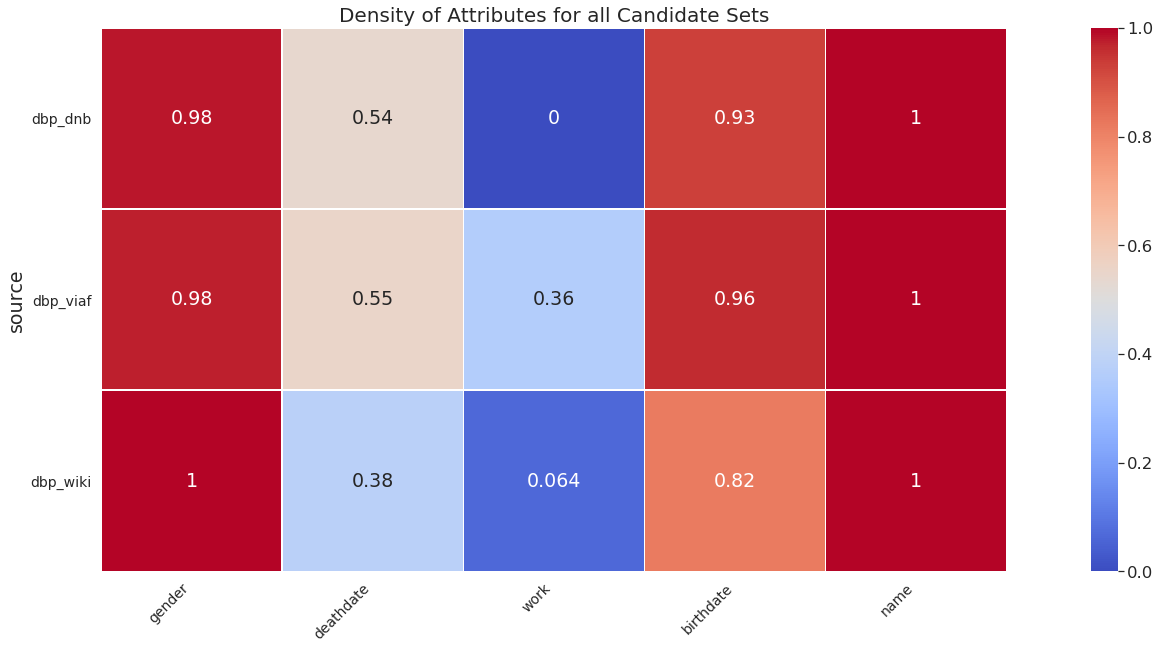

In [10]:
dex.plotDensityAttributesHeatmap(candsets)

In [11]:
# dense features for all combinations

# features excluded where the attribute has a very low density (<3%) for at 
# least one dataset that is involved either as source or target in the TL setting
rc_dbp_viaf_wiki = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

rc_dbp_dnb_wiki = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

rc_dbp_dnb_viaf = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

# assign the different feature sets (different dense features depending on combination)
dense_features_dict = {'dbp_viaf_wiki':rc_dbp_viaf_wiki,'dbp_dnb_wiki':rc_dbp_dnb_wiki,
                       'dbp_dnb_viaf':rc_dbp_dnb_viaf}

In [12]:
# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../results/benchmarks/'
supervised_results = 'authors_candsets_super_results'
unsupervised_results = 'authors_candsets_unsuper_results'

# we use the same random_state for all experiments
random_state = 42
# assign which sklearn estimators to use for the TL Experiment
#estimators_tl = {'logreg':LogisticRegression(random_state=random_state,solver='liblinear',max_iter=1000),
#                 'dectree':DecisionTreeClassifier(random_state=random_state),
#                 'randforest':RandomForestClassifier(random_state=random_state,n_estimators=10),
#                 'xgb':xgb.XGBClassifier(random_state=random_state,objective="binary:logistic"),
#                 'svm':LinearSVC(random_state=random_state,dual=False),
#                 #'svm':SVC(random_state=random_state,kernel='linear'),
#                 'logregcv':LogisticRegressionCV(random_state=random_state,cv=5,solver='liblinear',max_iter=1000)}

#### Import Passive Learning Baseline Results

In [13]:
candsets_super_results = sup.importJSONFileInDict(path_to_directory+supervised_results)

#### Import Unsupervised Learning Results

In [14]:
candsets_unsuper_results = sup.importJSONFileInDict(path_to_directory+unsupervised_results)

## AL_RF Unsupervised Bootstrap

### For all combinations

In [24]:
# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
feature = all_feature
query_strategies = ['lr_lsvc_rf_dt_xgb','random']
estimators = ['rf']
warm_start = True
quota = 100
disagreement = 'vote'
n = 5
# ***********************************************

al_results_unsup = al_unsup.al_unsup_boot_all(candsets,candsets_train,candsets_test,feature,
                                              estimators,query_strategies,quota,warm_start,
                                              reweight='score_based',disagreement='vote',n=5)

Start with AL using different settings for dbp_dnb
Start with Estimator: rf
Start with Query Strategy: lr_lsvc_rf_dt_xgb
Starting AL Experiments with Unsupervised Bootstrapping for target dbp_dnb
1. Run of 5
Initialize Dataset Object
Elbow_Threshold: 0.73007960788113 and Index: 9993
Initialize Learning Model
Initialize Query Strategy
Labeled weight: 1
Warm start: True
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Last iteration Performance on Target Test Set: F1 0.96; Prec 0.97; Recall 0.96
Average depth of trees at start (iteration 0): 9.7 at last iteration 4.5576923076923075
Initial weights of queried pairs: Counter({0.1: 22, 0.5: 15, 0.6: 15, 0.7: 15, 0.0: 13, 0.2: 6, 0.9: 4, 0.4: 3, 0.8: 3, 0.3: 3, 1.0: 1})
Runtime: 63.75 seconds
Correctness of unsupervised Pool:  0.887
2. Run of 5
Initialize Dataset Object
Elbow_Threshold: 0.73007960788113 and Index: 9993
Initialize Learning Model
Initialize Query Strategy
Labeled weight: 1
Warm start: True
Progres

Initialize Learning Model
Initialize Query Strategy
Labeled weight: 1
Warm start: True
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Last iteration Performance on Target Test Set: F1 0.99; Prec 1.00; Recall 0.99
Average depth of trees at start (iteration 0): 7.7 at last iteration 4.903846153846154
Initial weights of queried pairs: Counter({0.4: 20, 0.3: 20, 0.1: 16, 0.5: 15, 0.2: 14, 0.0: 10, 0.6: 4, 0.7: 1})
Runtime: 81.08 seconds
Correctness of unsupervised Pool:  0.391
5. Run of 5
Initialize Dataset Object
Elbow_Threshold: 0.4764040887265719 and Index: 3581
Initialize Learning Model
Initialize Query Strategy
Labeled weight: 1
Warm start: True
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.99
Average depth of trees at start (iteration 0): 7.7 at last iteration 4.548076923076923
Initial weights of queried pairs: Counter({0.5: 26, 0.4: 18, 0.1: 18

Initialize Learning Model
Initialize Query Strategy
Labeled weight: 1
Warm start: True
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Last iteration Performance on Target Test Set: F1 0.95; Prec 1.00; Recall 0.90
Average depth of trees at start (iteration 0): 9.6 at last iteration 2.3413461538461537
Initial weights of queried pairs: Counter({0.4: 23, 0.3: 18, 0.2: 17, 0.6: 11, 0.5: 7, 0.1: 6, 0.0: 6, 0.7: 4, 0.9: 3, 0.8: 3, 1.0: 2})
Runtime: 28.28 seconds
Correctness of unsupervised Pool:  0.363
3. Run of 5
Initialize Dataset Object
Elbow_Threshold: 0.4976431536698465 and Index: 2599
Initialize Learning Model
Initialize Query Strategy
Labeled weight: 1
Warm start: True
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Last iteration Performance on Target Test Set: F1 0.95; Prec 1.00; Recall 0.90
Average depth of trees at start (iteration 0): 9.3 at last iteration 2.1490384615384617
Initial weights of queried pairs: Counter({0

In [25]:
#sup.saveResultsToJSON(al_results_unsup,'../../results/benchmarks/authors_al_unsup_results')

Saved in ../../results/benchmarks/authors_al_unsup_results_20200719.json


### ATLX results

In [16]:
# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
query_strategies = ['lr_lsvc_rf_dt_xgb','random']
warm_start = True
weighting = [None,'nn','lrcv_predict_proba']
quota = 100
disagreement = 'vote'
n = 5
bootstrap_clf = 'rf'
n_bootstrapped_samples = 2
# ***********************************************
atlx_2 = atlx.atlx_all(candsets,candsets_train,candsets_test,dense_features_dict,
                             bootstrap_clf,query_strategies,quota,warm_start,
                             n_bootstrapped_samples,weighting,disagreement,
                             n,switch_roles=True)

Start with ATL using different settings for source dbp_dnb and target dbp_wiki
Start with Estimator: rf
Start with Query Strategy: lr_lsvc_rf_dt_xgb
Start with Weighting Strategy: None
No Unsupervised Domain Adaptation performed
Starting ATL Experiments (WITH transfer!) source dbp_dnb and target dbp_wiki
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.99
Average depth of trees at start (iteration 0): 19.5 at last iteration 5.769230769230769
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 90.74 seconds
Corrected labels from transfer: 29
2. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.99
Average depth of trees at start (iteration 0): 19.5 at last iteration 6.0048076923076925
Progress: |███████████████████████████████

Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.88; Prec 0.97; Recall 0.81
Average depth of trees at start (iteration 0): 19.5 at last iteration 2.25
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 30.65 seconds
Corrected labels from transfer: 1
Start with Weighting Strategy: nn
Unsupervised Domain Adaptation: Calculate sample_weight for the source instances using nn
Starting ATL Experiments (WITH transfer!) source dbp_dnb and target dbp_wiki
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.99; Recall 0.95
Average depth of trees at start (iteration 0): 21.2 at last iteration 2.5673076923076925
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 27.09 seconds
Corrected labels from transfer: 1
2. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Last iteration Performance on Target Test Set: F1 0.98; Prec 0.99; Recall 0.98
Average depth of trees at start (iteration 0): 20.7 at last iteration 5.461538461538462
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 89.51 seconds
Corrected labels from transfer: 12
4. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.98; Prec 0.99; Recall 0.98
Average depth of trees at start (iteration 0): 20.7 at last iteration 5.918269230769231
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 90.49 seconds
Corrected labels from transfer: 16
5. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.98
Average depth of trees at start (iteration 0): 20.7 at last iteration 5.831730769230769
Progress: |██████████████████████████████████

Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.99; Recall 0.95
Average depth of trees at start (iteration 0): 17.2 at last iteration 5.759615384615385
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 78.92 seconds
Corrected labels from transfer: 17
3. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.98; Recall 0.96
Average depth of trees at start (iteration 0): 17.2 at last iteration 5.764423076923077
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 87.50 seconds
Corrected labels from transfer: 19
4. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.98; Recall 0.95
Average depth of trees at start (iteration 0): 17.2 at last iteration 5.5
Progress: |██████████████████████

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.99
Average depth of trees at start (iteration 0): 18.3 at last iteration 6.360576923076923
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 101.63 seconds
Corrected labels from transfer: 12
5. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.99
Average depth of trees at start (iteration 0): 18.3 at last iteration 5.841346153846154
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 110.55 seconds
Corrected labels from transfer: 12
Start with Weighting Strategy: lrcv_predict_proba
Unsupervised Domain Adaptation: Calculate sample_weight for the source instances using lrcv_predict_proba
Starting ATL Experiments (WITH transfer!) source dbp_viaf and target dbp_wiki
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
In

Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.98; Prec 0.99; Recall 0.97
Average depth of trees at start (iteration 0): 17.4 at last iteration 2.798076923076923
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 29.21 seconds
Corrected labels from transfer: 0
4. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 1.00; Recall 0.95
Average depth of trees at start (iteration 0): 17.4 at last iteration 2.5961538461538463
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 29.13 seconds
Corrected labels from transfer: 0
5. Run of 5
Initialize Dataset Object
Initialize Learning Model
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.98; Prec 0.98; Recall 0.97
Average depth of trees at start (iteration 0): 17.4 at last iteration 2.5673076923076925
Progress: |████████

In [17]:
#sup.saveResultsToJSON(atlx_2,'../../results/atlx/authors_atlx_2')

Saved in ../../results/atlx/authors_atlx_2.json


#### Different Bootstrap Sample Size

In [42]:
# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
query_strategies = ['lr_lsvc_rf_dt_xgb','random']
warm_start = True
weighting = [None,'nn','lrcv_predict_proba']
quota = 100
disagreement = 'vote'
n = 5
bootstrap_clf = 'rf'
n_bootstrapped_samples = 10
# ***********************************************
atlx_10 = atlx.atlx_all(candsets,candsets_train,candsets_test,dense_features_dict,
                             bootstrap_clf,query_strategies,quota,warm_start,
                             n_bootstrapped_samples,weighting,disagreement,
                             n,switch_roles=True)

Start with ATL using different settings for source dbp_dnb and target dbp_wiki
Start with Estimator: rf
Start with Query Strategy: lr_lsvc_rf_dt_xgb
Start with Weighting Strategy: None
No Unsupervised Domain Adaptation performed
Starting ATL Experiments (WITH transfer!) source dbp_dnb and target dbp_wiki
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.99; Prec 0.99; Recall 0.99
Average depth of trees at start (iteration 0): 19.5 at last iteration 6.269230769230769
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 74.60 seconds
Corrected labels from transfer: 28
2. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Init

Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.95; Recall 0.98
Average depth of trees at start (iteration 0): 19.5 at last iteration 2.6923076923076925
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 29.57 seconds
Corrected labels from transfer: 2
2. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.96; Prec 1.00; Recall 0.93
Average depth of trees at start (iteration 0): 19.5 at last iteration 2.3125
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 29.95 seconds
Corrected labels from transfer: 1
3. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90

n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.96; Prec 0.96; Recall 0.96
Average depth of trees at start (iteration 0): 20.0 at last iteration 5.548076923076923
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 74.90 seconds
Corrected labels from transfer: 37
2. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.96; Prec 0.98; Recall 0.95
Average depth of trees at start (iteration 0): 20.0 at last iteration 5.225961538461538
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 72.09 seconds
Corrected labels from transfer: 41
3. Run of 5
Initialize Dataset Object
Initia

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Last iteration Performance on Target Test Set: F1 0.94; Prec 0.89; Recall 0.99
Average depth of trees at start (iteration 0): 21.0 at last iteration 3.485576923076923
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 25.05 seconds
Corrected labels from transfer: 1
Start with Weighting Strategy: lrcv_predict_proba
Unsupervised Domain Adaptation: Calculate sample_weight for the source instances using lrcv_predict_proba
Starting ATL Experiments (WITH transfer!) source dbp_dnb and target dbp_viaf
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.96; Prec 0.98; Recall 0.95
Average depth of trees at start (iteration 0): 20.7 at last iteration 2.668269230769231
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 26.

n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.97; Recall 0.96
Average depth of trees at start (iteration 0): 16.9 at last iteration 5.889423076923077
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 68.15 seconds
Corrected labels from transfer: 22
Start with Weighting Strategy: lrcv_predict_proba
Unsupervised Domain Adaptation: Calculate sample_weight for the source instances using lrcv_predict_proba
Starting ATL Experiments (WITH transfer!) source dbp_viaf and target dbp_dnb
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.97; Prec 0.98; Recall 0.95
Average depth of trees at start (ite

n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.94; Prec 0.93; Recall 0.96
Average depth of trees at start (iteration 0): 16.9 at last iteration 3.4615384615384617
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 20.98 seconds
Corrected labels from transfer: 2
Start with Weighting Strategy: lrcv_predict_proba
Unsupervised Domain Adaptation: Calculate sample_weight for the source instances using lrcv_predict_proba
Starting ATL Experiments (WITH transfer!) source dbp_viaf and target dbp_dnb
1. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.93; Prec 0.92; Recall 0.94
Average depth of trees at start (ite

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Last iteration Performance on Target Test Set: F1 0.98; Prec 1.00; Recall 0.96
Average depth of trees at start (iteration 0): 17.2 at last iteration 2.9663461538461537
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 28.28 seconds
Corrected labels from transfer: 1
5. Run of 5
Initialize Dataset Object
Initialize Learning Model
n_labeled max, as specified upfront is 10
The actual amount of instances with a predict proba higher than 90% is 10
Initialize Query Strategy
Last iteration Performance on Target Test Set: F1 0.93; Prec 1.00; Recall 0.88
Average depth of trees at start (iteration 0): 17.2 at last iteration 2.1826923076923075
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Runtime: 29.91 seconds
Corrected labels from transfer: 0
Start with Weighting Strategy: nn
Unsupervised Domain Adaptation: Calculate sample_weight for the source instances using nn
Starting ATL Experiments (WITH transfer!) source dbp_viaf and 

In [43]:
#sup.saveResultsToJSON(atlx_10,'../../results/atlx/authors_atlx_10')

Saved in ../../results/atlx/authors_atlx_10_v2.json


## Import AL Unsup Boot (Baseline) and ATLX Results

In [16]:
al_results_unsup = sup.importJSONFileInDict('../../results/benchmarks/authors_al_unsup_results')

In [17]:
atlx_results_2 = sup.importJSONFileInDict('../../results/atlx/authors_atlx_2')

In [18]:
atlx_results_10 = sup.importJSONFileInDict('../../results/atlx/authors_atlx_10')

### Whole Table to see results per weighting for all combinations

**Otherwise impossible to get a general overview when only looking at each single plot**

In [23]:
selected_weighting = 'no_weighting'
selected_qs = None
max_quota = 100
df_no_weighting = dut.createDFwithAlUnsupandATLXResultsMoreItersUpToMaxQuota(atlx_results_2,al_results_unsup,
                                                             selected_weighting,candsets_super_results,
                                                             selected_qs,max_quota=100,
                                                            filename='../../results/atlx/authors_atlx_2_ws_nw')

Weighting: no_weighting and Query Strategy: None


In [25]:
selected_weighting = 'nn'
selected_qs = None
max_quota = 100
df_nn = dut.createDFwithAlUnsupandATLXResultsMoreItersUpToMaxQuota(atlx_results_2,al_results_unsup,
                                                                   selected_weighting,candsets_super_results,
                                                                   selected_qs,max_quota=100,
                                                                   filename='../../results/atlx/authors_atlx_2_ws_nn')

Weighting: nn and Query Strategy: None


In [19]:
selected_weighting = 'lrcv_predict_proba'
selected_qs = None
max_quota = 100
df_lprob = dut.createDFwithAlUnsupandATLXResultsMoreItersUpToMaxQuota(atlx_results_2,al_results_unsup,
                                                             selected_weighting,candsets_super_results,
                                                             selected_qs,max_quota=100,
                                                            filename='../../results/atlx/authors_atlx_2_ws_lp')

Weighting: lrcv_predict_proba and Query Strategy: None


In [21]:
selected_qs = 'lr_lsvc_rf_dt_xgb'
max_quota = 100

df_no_weighting_nn_lprob_compared = dut.createDFwithAlUnsupandATLXResultsToCompareDA(atlx_results_2,
                                                                                     al_results_unsup,
                                                                                     candsets_super_results,
                                                                                     selected_qs,max_quota,
                                                                                     filename=None)

All ATLX results with no_weighting and nn as well as lr_predict_proba (lp) and Query Strategy: lr_lsvc_rf_dt_xgb


In [22]:
df_model_change = dut.createDFModelChange(atlx_results_2,al_results_unsup,candsets_super_results,dense_features_dict,selected_qs=['lr_lsvc_rf_dt_xgb'],clf='rf',display_feature_importance=False,filename=None)

In [23]:
df_kpis = df_model_change.drop(columns=['f1_in_0','f1_in_-1','adt_0','adt_-1','c_0','c_-1','ordered_attr_import_0','ordered_attr_import_-1','top_5_feature_0','top_5_feature_-1'])

In [26]:
df_kpis.index = pd.MultiIndex.from_tuples([( 'dbp_dnb', 'dbp_wiki', '-'),
            ( 'dbp_dnb', 'dbp_wiki','nn'),
            ( 'dbp_dnb', 'dbp_wiki','lp'),
            ('dbp_wiki',  'dbp_dnb', '-'),
            ('dbp_wiki',  'dbp_dnb','nn'),
            ('dbp_wiki',  'dbp_dnb','lp'),
            ( 'dbp_dnb', 'dbp_viaf', '-'),
            ( 'dbp_dnb', 'dbp_viaf','nn'),
            ( 'dbp_dnb', 'dbp_viaf','lp'),
            ('dbp_viaf',  'dbp_dnb', '-'),
            ('dbp_viaf',  'dbp_dnb','nn'),
            ('dbp_viaf',  'dbp_dnb','lp'),
            ('dbp_wiki', 'dbp_viaf', '-'),
            ('dbp_wiki', 'dbp_viaf','nn'),
            ('dbp_wiki', 'dbp_viaf','lp'),
            ('dbp_viaf', 'dbp_wiki', '-'),
            ('dbp_viaf', 'dbp_wiki','nn'),
            ('dbp_viaf', 'dbp_wiki','lp')],
           names=['Source', 'Target', 'DA'])

In [27]:
dut.styleDFModelChange(df_kpis,False,filename='../../results/atlx/authors_2_kpis')

In [74]:
df_model_change = df_model_change[['ls','adt_0','adt_-1','c_0','c_-1','ordered_attr_import_0','ordered_attr_import_-1']].copy()

In [75]:
df_model_change.index = pd.MultiIndex.from_tuples([( 'dbp_dnb', 'dbp_wiki', '-'),
            ( 'dbp_dnb', 'dbp_wiki','nn'),
            ( 'dbp_dnb', 'dbp_wiki','lp'),
            ('dbp_wiki',  'dbp_dnb', '-'),
            ('dbp_wiki',  'dbp_dnb','nn'),
            ('dbp_wiki',  'dbp_dnb','lp'),
            ( 'dbp_dnb', 'dbp_viaf', '-'),
            ( 'dbp_dnb', 'dbp_viaf','nn'),
            ( 'dbp_dnb', 'dbp_viaf','lp'),
            ('dbp_viaf',  'dbp_dnb', '-'),
            ('dbp_viaf',  'dbp_dnb','nn'),
            ('dbp_viaf',  'dbp_dnb','lp'),
            ('dbp_wiki', 'dbp_viaf', '-'),
            ('dbp_wiki', 'dbp_viaf','nn'),
            ('dbp_wiki', 'dbp_viaf','lp'),
            ('dbp_viaf', 'dbp_wiki', '-'),
            ('dbp_viaf', 'dbp_wiki','nn'),
            ('dbp_viaf', 'dbp_wiki','lp')],
           names=['Source', 'Target', 'DA'])

In [76]:
dut.styleSimple(df_model_change,filename='../../results/atlx/authors_2_model_change')

## Plots

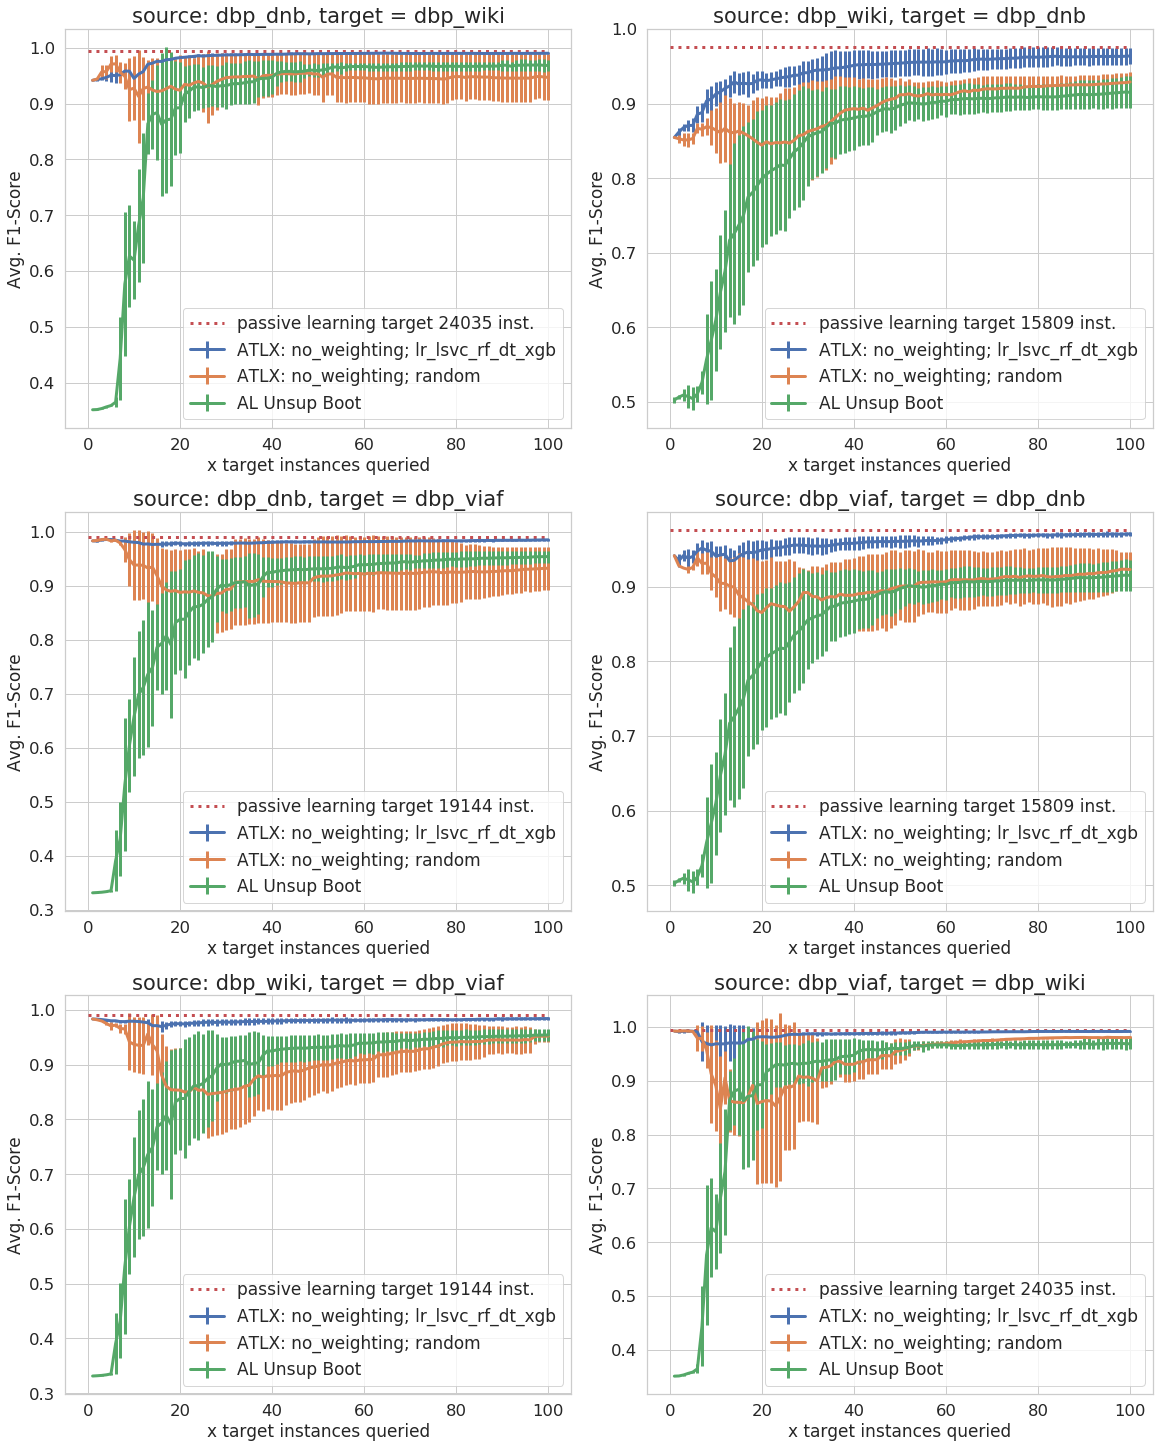

In [73]:
# ***CHANGE THE FOLLOWING VARIABLES AS DESIRED***
selected_estimator = ['rf']  # None means all! ['lr'] or ['xgb'] or ['lr','xgb']
selected_qs = None   # None means all! ['lr_lsvc_rf_dt','lr_lsvc_dt_xgb','random']
al_also = al_results_unsup  # None means only ATL Results are plotted. If al_also = al_results then also al results
selected_weights = ['no_weighting'] #['nn']
quota = 100
n = 5
warm_start=True
# ***********************************************

dut.plotATLXALUnsupResultsAll(atlx_results_2,quota,candsets,candsets_super_results,n,warm_start,
                              selected_estimator,al_also,selected_qs,
                              selected_weights,errorbars=True,saveFig=True,
                              path_for_output='../../results/atlx/authors_atlx_eval_plot_v2')

#### Transfer from dbp_wiki to dbp_dnb

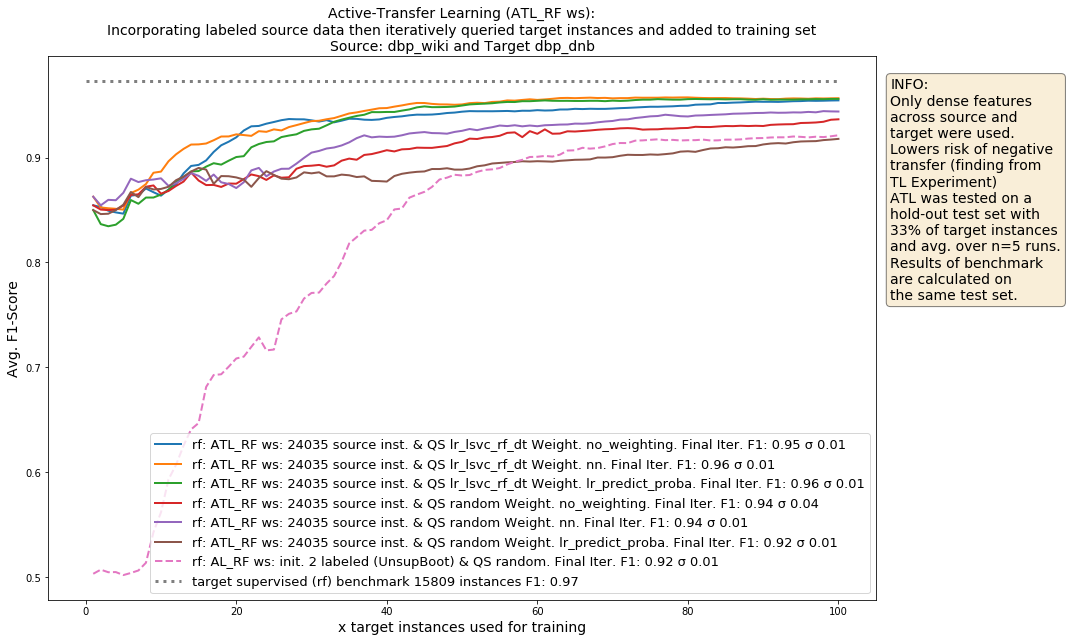

In [24]:
# ***CHANGE THE FOLLOWING VARIABLES AS DESIRED***
source_name = 'dbp_wiki'
target_name = 'dbp_dnb'
selected_estimator = ['rf']  # None means all! ['lr'] or ['xgb'] or ['lr','xgb']
selected_qs = None   # None means all! ['lr_lsvc_rf_dt','lr_lsvc_dt_xgb','random']
al_also = al_results_unsup  # None means only ATL Results are plotted. If al_also = al_results then also al results
selected_weights = None #['nn']
quota = 100
n = 5
warm_start=True
# ***********************************************

alut.plotATLRFALUnsupResults(atlx_warm_start,source_name,target_name,quota,candsets,candsets_super_results,
               n,warm_start,selected_estimator,al_also,selected_qs,selected_weights,errorbars=False,
                             ylim=None,saveFig=False,path_for_output='./graphics/custom_plots/')

#### Transfer from dbp_dnb to dbp_viaf

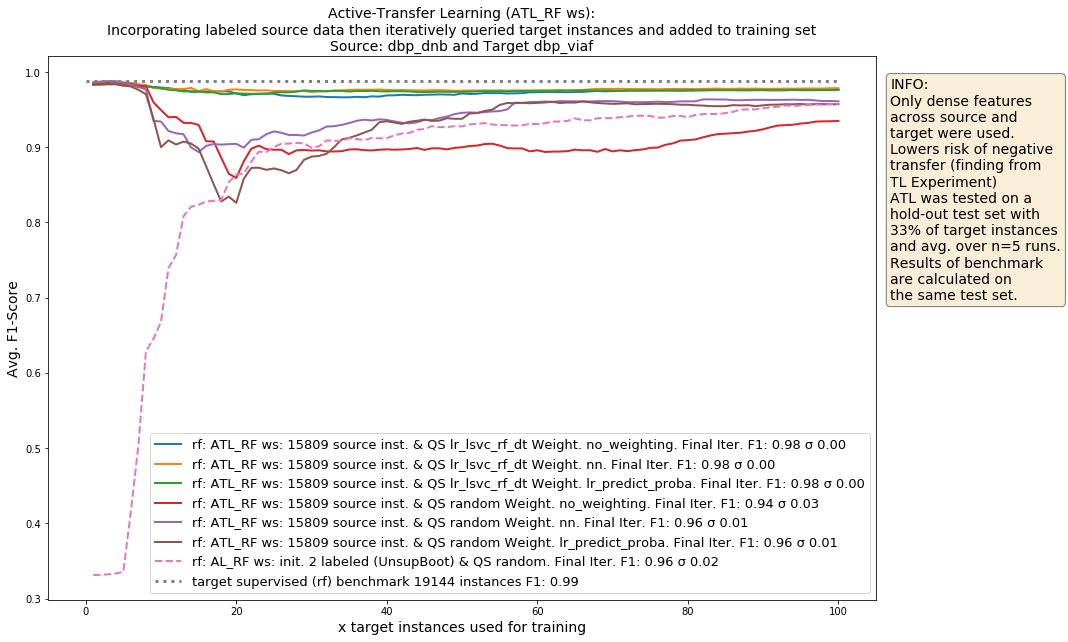

In [25]:
# ***CHANGE THE FOLLOWING VARIABLES AS DESIRED***
source_name = 'dbp_dnb'
target_name = 'dbp_viaf'
selected_estimator = ['rf']  # None means all! ['lr'] or ['xgb'] or ['lr','xgb']
selected_qs = None   # None means all! ['lr_lsvc_rf_dt','lr_lsvc_dt_xgb','random']
al_also = al_results_unsup  # None means only ATL Results are plotted. If al_also = al_results then also al results
selected_weights = None #['nn']
quota = 100
n = 5
warm_start=True
# ***********************************************

alut.plotATLRFALUnsupResults(atlx_warm_start,source_name,target_name,quota,candsets,candsets_super_results,
               n,warm_start,selected_estimator,al_also,selected_qs,selected_weights,errorbars=False,
                             ylim=None,saveFig=False,path_for_output='./graphics/custom_plots/')

#### Transfer from dbp_viaf to dbp_dnb

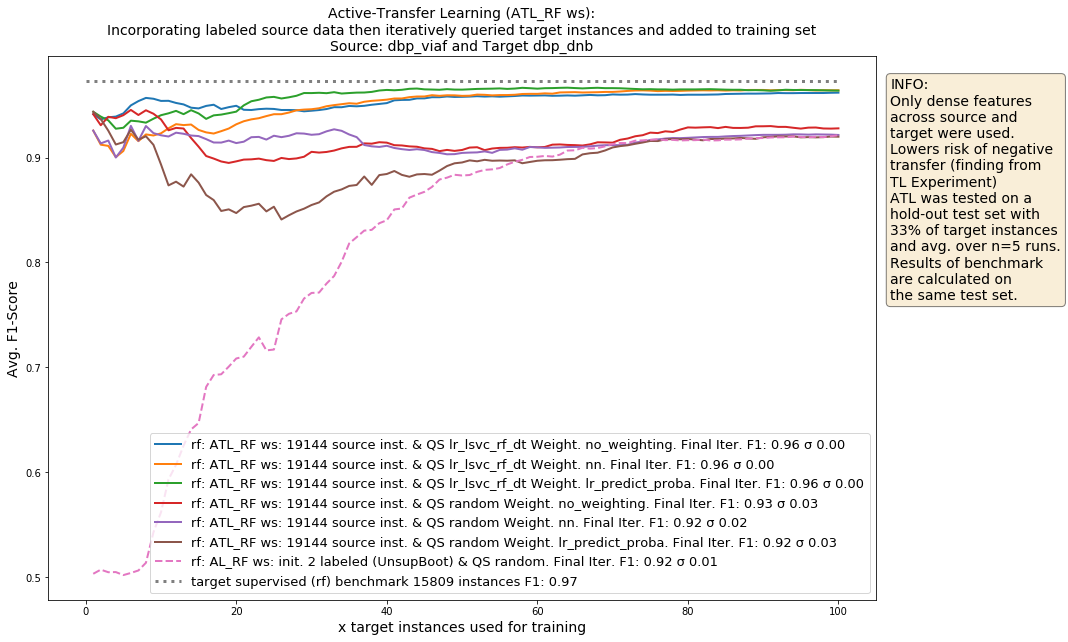

In [26]:
# ***CHANGE THE FOLLOWING VARIABLES AS DESIRED***
source_name = 'dbp_viaf'
target_name = 'dbp_dnb'
selected_estimator = ['rf']  # None means all! ['lr'] or ['xgb'] or ['lr','xgb']
selected_qs = None   # None means all! ['lr_lsvc_rf_dt','lr_lsvc_dt_xgb','random']
al_also = al_results_unsup  # None means only ATL Results are plotted. If al_also = al_results then also al results
selected_weights = None #['nn']
quota = 100
n = 5
warm_start=True
# ***********************************************

alut.plotATLRFALUnsupResults(atlx_warm_start,source_name,target_name,quota,candsets,candsets_super_results,
               n,warm_start,selected_estimator,al_also,selected_qs,selected_weights,errorbars=False,
                             ylim=None,saveFig=False,path_for_output='./graphics/custom_plots/')

#### Transfer from dbp_viaf to dbp_wiki

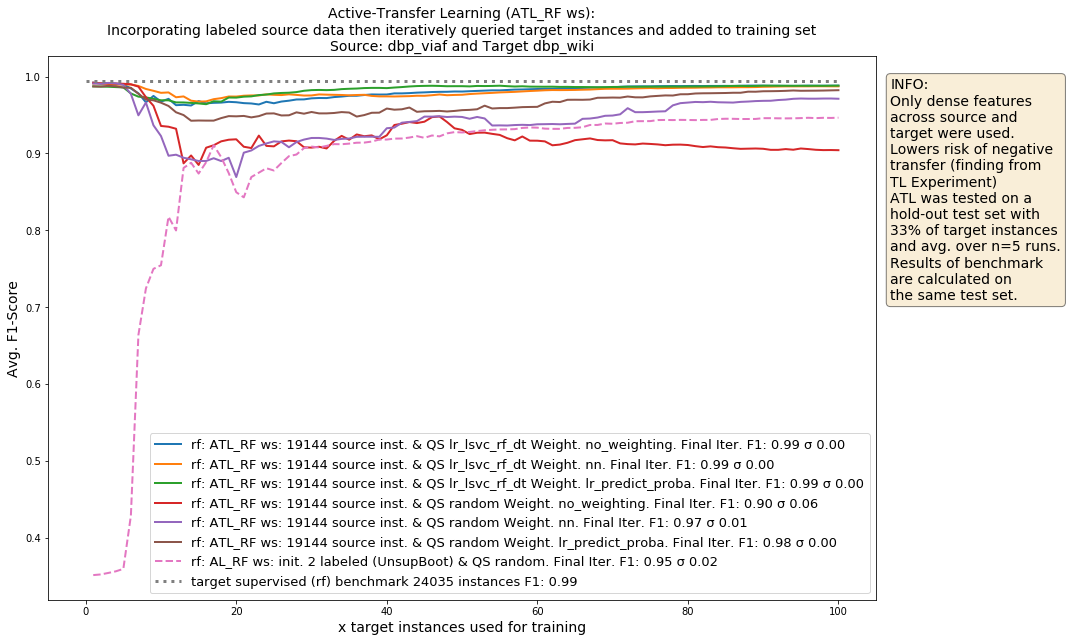

In [27]:
# ***CHANGE THE FOLLOWING VARIABLES AS DESIRED***
source_name = 'dbp_viaf'
target_name = 'dbp_wiki'
selected_estimator = ['rf']  # None means all! ['lr'] or ['xgb'] or ['lr','xgb']
selected_qs = None   # None means all! ['lr_lsvc_rf_dt','lr_lsvc_dt_xgb','random']
al_also = al_results_unsup  # None means only ATL Results are plotted. If al_also = al_results then also al results
selected_weights = None #['nn']
quota = 100
n = 5
warm_start=True
# ***********************************************

alut.plotATLRFALUnsupResults(atlx_warm_start,source_name,target_name,quota,candsets,candsets_super_results,
               n,warm_start,selected_estimator,al_also,selected_qs,selected_weights,errorbars=False,
                             ylim=None,saveFig=False,path_for_output='./graphics/custom_plots/')

#### Transfer from dbp_viaf to dbp_wiki

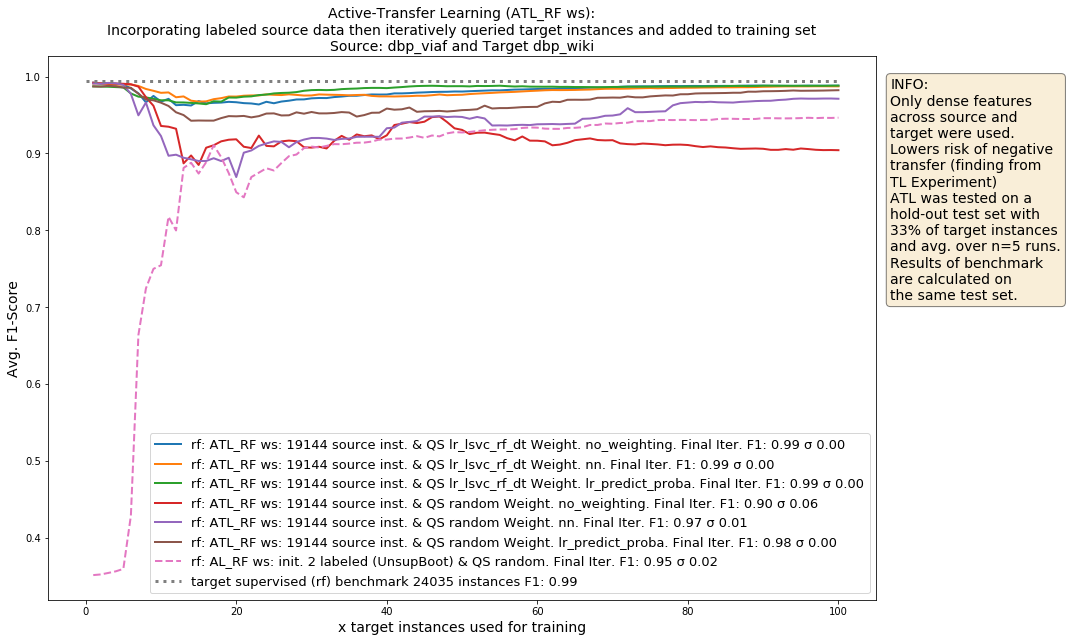

In [28]:
# ***CHANGE THE FOLLOWING VARIABLES AS DESIRED***
source_name = 'dbp_viaf'
target_name = 'dbp_wiki'
selected_estimator = ['rf']  # None means all! ['lr'] or ['xgb'] or ['lr','xgb']
selected_qs = None   # None means all! ['lr_lsvc_rf_dt','lr_lsvc_dt_xgb','random']
al_also = al_results_unsup  # None means only ATL Results are plotted. If al_also = al_results then also al results
selected_weights = None #['nn']
quota = 100
n = 5
warm_start=True
# ***********************************************

alut.plotATLRFALUnsupResults(atlx_warm_start,source_name,target_name,quota,candsets,candsets_super_results,
               n,warm_start,selected_estimator,al_also,selected_qs,selected_weights,errorbars=False,
                             ylim=None,saveFig=False,path_for_output='./graphics/custom_plots/')